# PCA Market Portfolio

In this notebook we are going to scrap the sp500 data, then construct a PCA selected portfolio. Furthermore we will compare the PCA portfolio with an sp500 etf.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import bs4 as bs
import requests
import datetime
start = datetime.datetime(2020,2,1)
end = datetime.date.today()
from IPython.core.pylabtools import figsize
figsize(12.0, 8.0)

import sys
sys.path.insert(0, '../../scripts/')

from database import Stock

plt.style.use('dark_background')

### SP500 Stocks 

In [17]:
def save_sp500_tickers():

    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'html')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        if not '.' in ticker:
            tickers.append(ticker.replace('\n',''))
        
    return tickers

tickers = save_sp500_tickers()

In [18]:
tmp_ = dict()
for tic in tickers:
    stk = Stock(tic, start, end).df
    tmp_[tic] = stk["Close"]
stocks = pd.DataFrame(tmp_)    

In [19]:
rs = stocks.apply(np.log).diff(1)

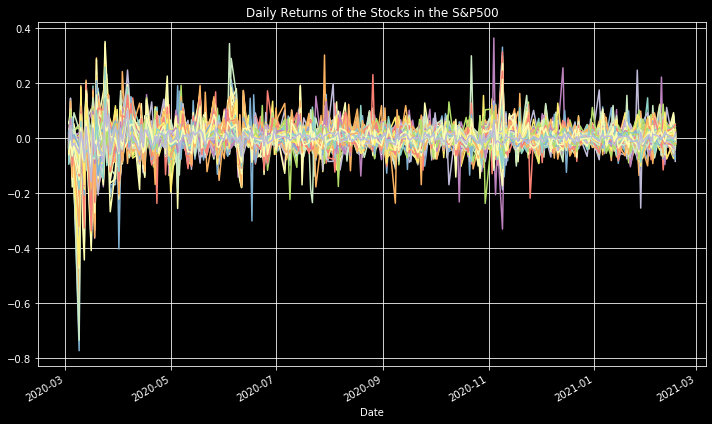

In [20]:
rs.plot(legend=0, figsize=(10,6), grid=True, title='Daily Returns of the Stocks in the S&P500')
plt.tight_layout()


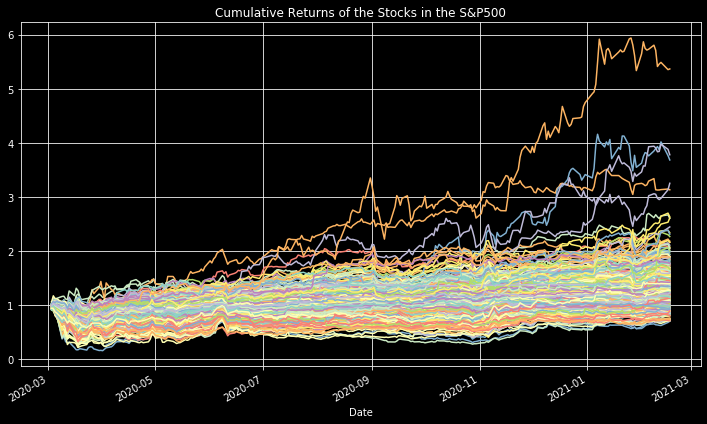

In [21]:
(rs.cumsum().apply(np.exp)).plot(legend=0, figsize=(10,6), grid=True, title='Cumulative Returns of the Stocks in the S&P500')
plt.tight_layout()

### PCA

In [22]:
from sklearn.decomposition import PCA

In [23]:
pca = PCA(1).fit(rs.fillna(0))

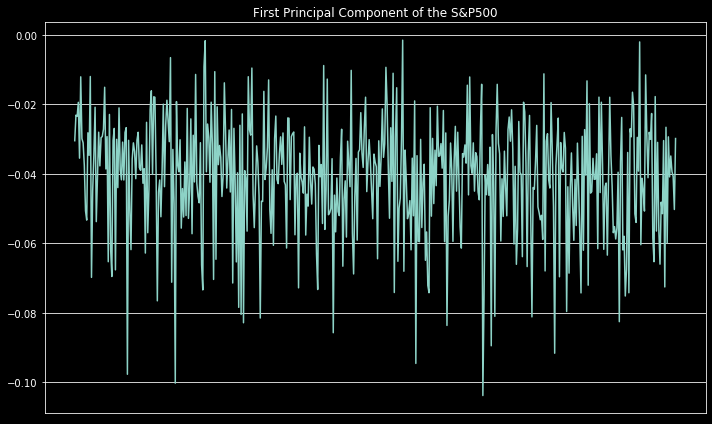

In [24]:
pc1 = pd.Series(index=rs.columns, data=pca.components_[0])
pc1.plot(figsize=(10,6), xticks=[], grid=True, title='First Principal Component of the S&P500')
plt.tight_layout()

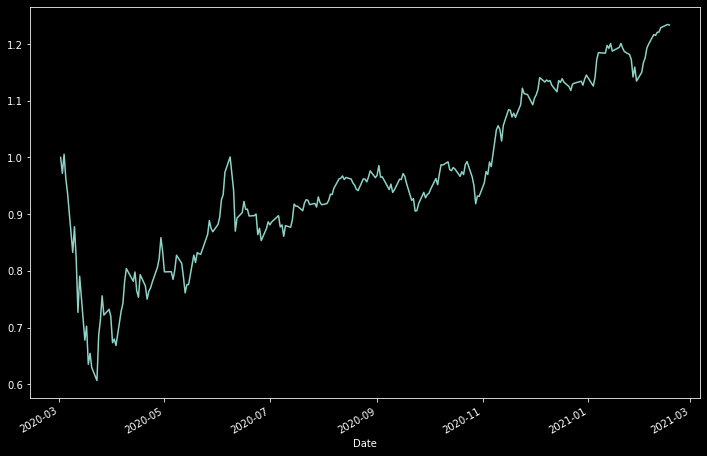

In [25]:
weights = abs(pc1)/sum(abs(pc1))
myrs = (weights*rs).sum(1)
myrs.cumsum().apply(np.exp).plot()

### Compare SP500 ETF to PCA Market Portfolio

In [26]:
spy = Stock('SPY', start, end).df
spy = spy['Close']

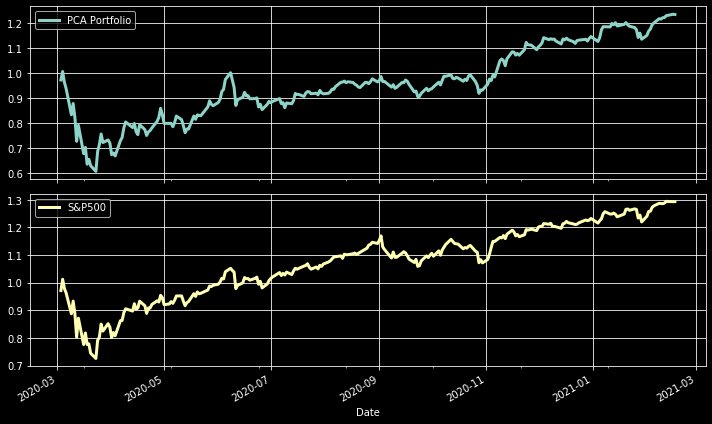

In [27]:
rs_df = pd.concat([myrs, spy.apply(np.log).diff(1)], 1)
rs_df.columns = ["PCA Portfolio", "S&P500"]

rs_df.dropna().cumsum().apply(np.exp).plot(subplots=True, figsize=(10,6), grid=True, linewidth=3);
plt.tight_layout()

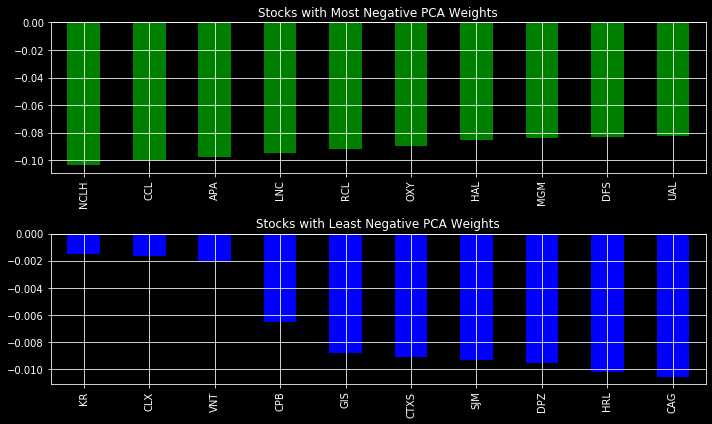

In [28]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
pc1.nsmallest(10).plot.bar(ax=ax[0], color='green', grid=True, title='Stocks with Most Negative PCA Weights')
pc1.nlargest(10).plot.bar(ax=ax[1], color='blue', grid=True, title='Stocks with Least Negative PCA Weights')

plt.tight_layout()

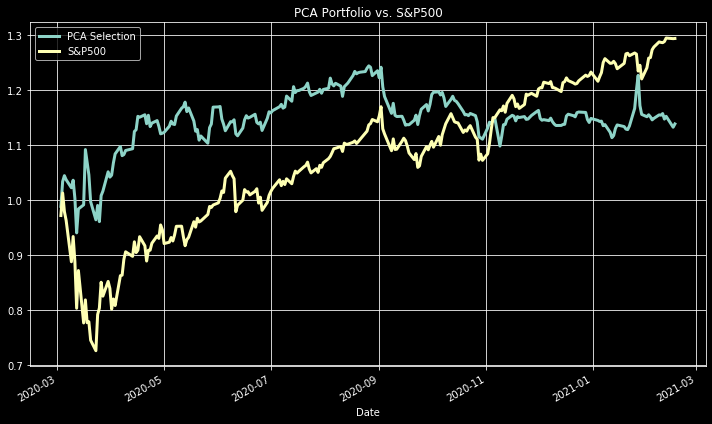

In [29]:
myrs = rs[pc1.nlargest(10).index].mean(1)
myrs.cumsum().apply(np.exp).plot(figsize=(15,5), grid=True, linewidth=3, title='PCA Portfolio vs. S&P500')
spy.apply(np.log).diff(1).cumsum().apply(np.exp).plot(figsize=(10,6), grid=True, linewidth=3)
plt.legend(['PCA Selection', 'S&P500'])

plt.tight_layout()

In [30]:
pc1.nlargest(10).index

Index(['KR', 'CLX', 'VNT', 'CPB', 'GIS', 'CTXS', 'SJM', 'DPZ', 'HRL', 'CAG'], dtype='object')